# The Early Net: Preventing Stroke in Older Adults with Proactive BP Screening

```
Stroke = IS (ischemic) + TIA (transient ischemic attack) + ICH (hemorrhagic)
Stroke prevention = Prevent first stroke + Prevent second stroke
Proactive BP Monitoring = Ambulatory monitoring / Periodic mass screening
	Screening for: variation in BP + hypertension	
Opportunistic BP Monitoring = Check during visit
Older adults = 55-80 yrs
```
## Executive Summary

Research suggests that 
-	(8) Ambulatory BP monitoring: profiling BP can identify higher risk of stroke
-	(10) BP variation (BPV) associated with increased risk of stroke, especially in terms of time of variation.
-	(13) BP trajectory related to clinical outcomes of IS patients

Further investigations mandate a dual approach…

## Literature Review

### Problem Statement

Stroke occurs when blood supply to a part of brain is cut off, causing brain tissue damage, while it is well-known that hypertension (HT), or high blood pressure (BP), is a leading cause of stroke, and poor treatment of HT often results in higher stroke risk. In Hong Kong, the CDCC Pilot Scheme (ref) was introduced to help supporting treating hypertension, but the scheme only subsidizes 6 annual consultations, with no mention of implementing proactive BP monitoring. Therefore, it is not guaranteed for the HT condition of the patient to be treated optimally, and between consultations, the patient’s BP cannot be guaranteed to be proactively monitored.

### Significance

Causing 2,911 deaths, stroke was the 4th most common cause of death in Hong Kong in 2024 (Centre for Health Prevention, 2025), and has a higher incidence among those aged over 55 (Boehme et al., 2017). Also, it is found that poorly treated and undetected HT leads to higher hazard risks (HR) of stroke than in those whose HT is controlled (Han et al., 2017). If the population particularly susceptible to stroke can be screened at an early stage (by monitoring the ambulatory BP), and intervening with suitable BP management treatments, stroke could be prevented, saving thousands of lives each year.

### Objectives

This study aims to identify the necessity for frequent, proactive BP monitoring for preventing stroke in the aged population. Specifically,

1.	Compare existing datasets to find correlation between BP and stroke, and longitudinal BP trends predict first-ever stroke occurrence in adults aged 55-80.
2.	Identify high-risk groups with long-term health issues or lifestyle factors (e.g., diet or consumption of certain drinks) that could lead to higher absolute stroke risk, therefore defining groups for prioritized BP screening.
3.	Assess whether baseline treatment status (e.g., use of HT drugs) could mediate or reduce correlation between BP trends and stroke risk.
4.	Explore correlation between recent symptoms and care-seeking behavior and short-term stroke risk.
5.	Generate candidate, easy to apply screening criteria (rule sets or risk score cut-points) that prioritize individuals for proactive monitoring, and report their predictive performance and likely population yield.

## Data analysis

### Methodology

A retrospective cohort is used to compare trends in BP (systolic and diastolic) that may lead to stroke.

At baseline, individuals aged 55-80 and free of stroke are included. Only individuals that appeared across 3 or more “waves” (statistical periods) are included.

### Data Import
This part processes necesary data to prepare for analysis.

Data source: https://chns.cpc.unc.edu/

China Health and Nutrition Survey. Licensed under CC0.

#### Abbrevations
- CHNS - China Health and Nutrition Survey
- CHNS_Idv - Individual datasets from CHNS

All datasets provided are in the SAS format. They are read into Pandas DataFrames first for further processing.

In [3]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from matplotlib import pyplot as plt

%matplotlib widget

#### Clean up Data

CHNS uses a set of codes to name their data colums, which are available with the datasets. Individuals have a unique ID assigned to them, which is persistent across waves (years where CHNS is taken place). This means that one can combine individual data across waves for longitudinal study.

For the sake of simplicity, only statistical data collected that are related to cardiovascular and cerebrovascular problems are taken into consideration. The following are factors included.

- Age
- Gender
- Had a headache in last 4 weeks?
- Had chest pain in last 4 weeks?
- Felt exhausted in last 4 weeks?
- Had bleeding of unknown cause in last 4 weeks?
- Had weight loss of unknown cause in last 4 weeks?
- Did the patient seek medical care?
- Systolic blood pressure (take mean of 3 values)
- Diastolic blood pressure (take mean of 3 values)
- BMI (calculated from height and weight)
    - Height
    - Weight
- Has hypertension?
    - Number of years with hypertension
    - Is the patient taking HT drugs?
- Has diabetes?
    - Number of years with diabetes (calculated with age)
        - Age when first diagnosed diabetes
- Has myocardiac infarction (MI)?
    - Number of years with MI (calculated with age)
        - Age when first diagnosed MI
- Has apoplexy?
    - Number of years with apoplexy (calculated with age)
        - Age when diagnosed apoplexy
- Had a transient ischemic attack (TIA) in the past year?
    - Number of years since first TIA diagnosed (calculated with age)
        - Age when diagnosed TIA
- Had ever smoked?
    - Age when first smoked?
    - Still smoking or quitted?
    - Number of cigarettes smoked per day.
- Drinks beer?
    - Number of bottles of beer per week
    - Frequency of drinking beer per week
- Drinks tea?
    - Number of bottles of tea per week
    - Frequency of drinking tea per week
- Drinks coffee?
    - Number of bottles of coffee per week
    - Frequency of drinking coffee per week

Frequency of all `_Freq` columns are encoded as follows:

1. Almost every day
2. 4-5 times a week
3. 2-3 times a week
4. No more than once a week
5. 2-3 times in past 30 days
6. Only once in past 30 days
7. None in past 30 days

In [4]:
hlth_data = pd.read_sas("CHNS_Idv/hlth_12.sas7bdat")

hlth_data["wave"] = hlth_data["wave"].astype(int)
hlth_data["IDind"] = hlth_data["IDind"].astype(int)
hlth_cols = {
    "IDind"    : "ID",
    "M24B_3"   : "Headache_Last4",
    "M24B_7"   : "Chestpain_Last4",
    "M24B_14"  : "Exhaustion_Last4",
    "M24B_15"  : "Unknown_Bleed_Last4",
    "M24B_16"  : "Unknown_WghtLoss_Last4",
    "M26"      : "Sought_Medcare",
    "wave"     : "Wave",
}

hlth_data = hlth_data[[*hlth_cols.keys()]]
hlth_data = hlth_data.rename(columns=hlth_cols)
hlth_data = hlth_data.sort_values("ID")

hlth_data = hlth_data.fillna(0)
    
hlth_data = hlth_data.reset_index(drop=True)
hlth_data

,ID,Headache_Last4,Chestpain_Last4,Exhaustion_Last4,Unknown_Bleed_Last4,Unknown_WghtLoss_Last4,Sought_Medcare,Wave
0,111101001001,1.0,0.0,0.0,0.0,0.0,0.0,2011
1,111101001001,0.0,0.0,0.0,0.0,0.0,0.0,2015
2,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2011
3,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2015
4,111101002001,1.0,0.0,0.0,0.0,0.0,0.0,2011
...,...,...,...,...,...,...,...,...
127756,552304020003,0.0,0.0,0.0,0.0,0.0,0.0,2015
127757,552304161001,0.0,0.0,0.0,0.0,0.0,0.0,2015
127758,552304161002,0.0,0.0,0.0,0.0,0.0,0.0,2015
127759,552304161003,0.0,0.0,0.0,0.0,0.0,0.0,2015


In [5]:
exam_data = pd.read_sas("CHNS_Idv/pexam_00.sas7bdat")

exam_cols = {
    "SYSTOL1"  : "Systole_BP1",
    "SYSTOL2"  : "Systole_BP2",
    "SYSTOL3"  : "Systole_BP3",
    "DIASTOL1" : "Diastole_BP1",
    "DIASTOL2" : "Diastole_BP2",
    "DIASTOL3" : "Diastole_BP3",
    "HEIGHT"   : "Height",
    "WEIGHT"   : "Weight",
    "U22"      : "Has_HT",
    "U23"      : "HT_Years",
    "U24"      : "HT_OnHTDrugs",
    "U24A"     : "Has_Diab",
    "U24B"     : "Diab_Age",
    "U24C"     : "Diab_OnDiet",
    "U24D"     : "Diet_OnWeightCtrl",
    "U24E"     : "Diab_OnOralMeds",
    "U24F"     : "Diab_OnInsulin",
    "U24J"     : "Has_MI",
    "U24K"     : "MI_Age",
    "U24L"     : "Has_Apopl",
    "U24M"     : "Apopl_Age",
    "U24V"     : "Had_TIA",
    "U24T"     : "TIA_Age",
    "U24R"     : "Has_Whistle",
    "U24S"     : "Whistle_Years",
    "U25"      : "Had_Smoke",
    "U26"      : "Age_Smoke",
    "U27"      : "Still_Smoking",
    "U28"      : "Num_Cigs_Day",
    "U34"      : "Drink_Tea",
    "U35"      : "Freq_Tea",
    "U36"      : "Avg_Tea_Cups_Day",
    "U37"      : "Drink_Coffee",
    "U38"      : "Freq_Coffee",
    "U39"      : "Avg_Coffee_Cups_Day",
    "U40"      : "Drink_Beer",
    "U41"      : "Freq_Beer",
    "U42"      : "Avg_Beer_Bottles_Day",
    "IDind"    : "ID",
    "WAVE"     : "Wave",
}

exam_data["WAVE"] = exam_data["WAVE"].astype(int)
exam_data["IDind"] = exam_data["IDind"].astype(int)

exam_data = exam_data[[*exam_cols.keys()]]
exam_data = exam_data.rename(columns=exam_cols)
exam_data = exam_data.sort_values("ID")

# Deal with NaN
exam_data = exam_data[exam_data["Systole_BP1"].notna()]
exam_data = exam_data[exam_data["Height"].notna()]
exam_data = exam_data[exam_data["Weight"].notna()]

exam_data = exam_data.fillna(0)

# Take mean of SBP and DBP
exam_data["SBP_Mean"] = sum([exam_data["Systole_BP1"], exam_data["Systole_BP2"], exam_data["Systole_BP3"]]) / 3
exam_data["DBP_Mean"] = sum([exam_data["Diastole_BP1"], exam_data["Diastole_BP2"], exam_data["Diastole_BP3"]]) / 3

# Calculate BMI
exam_data["Height"] /= 100
exam_data["BMI"] = exam_data["Weight"] / exam_data["Height"] ** 2

for column_name in exam_cols.values():
    if column_name.startswith("Has_") or column_name.startswith("Drink_") or column_name.startswith("Had"):
        exam_data[column_name] = exam_data[column_name].astype(int)

exam_data = exam_data.reset_index(drop=True)
exam_data

,Systole_BP1,Systole_BP2,Systole_BP3,Diastole_BP1,Diastole_BP2,Diastole_BP3,Height,Weight,Has_HT,HT_Years,...,Freq_Coffee,Avg_Coffee_Cups_Day,Drink_Beer,Freq_Beer,Avg_Beer_Bottles_Day,ID,Wave,SBP_Mean,DBP_Mean,BMI
0,140.0,138.0,140.0,90.0,86.0,88.0,1.660,72.0,1,30.0,...,0.0,0.0,0,0.0,0.0,111101001001,2011,139.333333,88.000000,26.128611
1,120.0,124.0,120.0,70.0,72.0,68.0,1.570,53.0,1,35.0,...,0.0,0.0,0,0.0,0.0,111101001002,2011,121.333333,70.000000,21.501886
2,120.0,126.0,120.0,80.0,82.0,76.0,1.680,83.5,1,1.0,...,0.0,0.0,0,0.0,0.0,111101002001,2011,122.000000,79.333333,29.584751
3,140.0,138.0,140.0,80.0,76.0,86.0,1.690,63.0,1,11.0,...,0.0,0.0,0,0.0,0.0,111101003001,2011,139.333333,80.666667,22.058051
4,110.0,114.0,110.0,78.0,80.0,76.0,1.600,50.0,0,0.0,...,0.0,0.0,0,0.0,0.0,111101003002,2011,111.333333,78.000000,19.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94528,100.0,102.0,102.0,70.0,68.0,70.0,1.423,36.9,0,0.0,...,0.0,0.0,0,0.0,0.0,552304018003,2011,101.333333,69.333333,18.222861
94529,150.0,148.0,150.0,96.0,94.0,94.0,1.556,59.8,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019001,2011,149.333333,94.666667,24.699149
94530,108.0,108.0,106.0,64.0,66.0,62.0,1.504,54.2,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019002,2011,107.333333,64.000000,23.960927
94531,124.0,126.0,126.0,88.0,90.0,88.0,1.664,56.1,0,0.0,...,0.0,0.0,0,0.0,0.0,552304020001,2011,125.333333,88.666667,20.260783


In [6]:
birth_data = pd.read_sas("CHNS_Idv/mast_pub_12.sas7bdat")

birth_data["Idind"] = birth_data["Idind"].astype(int)
birth_data["GENDER"] = birth_data["GENDER"].astype(int)

birth_cols = {"Idind": "ID", "GENDER": "Gender", "WEST_DOB_Y": "DOB"}
birth_data = birth_data[[*birth_cols.keys()]]
birth_data = birth_data.rename(columns=birth_cols)
birth_data = birth_data.dropna()
birth_data = birth_data.drop_duplicates()

birth_data["DOB"] = birth_data["DOB"].astype(int)
birth_data = birth_data.sort_values("ID")

birth_data = birth_data.reset_index(drop=True)
birth_data

,ID,Gender,DOB
0,111101001001,1,1935
1,111101001002,2,1936
2,111101002001,2,1964
3,111101003001,1,1932
4,111101003002,2,1937
...,...,...,...
39646,552304020003,1,2009
39647,552304161001,1,1971
39648,552304161002,1,2011
39649,552304161003,2,2008


#### Merge and filter

Merge health data and health examination data. Then filter out individuals:

- Not aged 55-80 at baseline
- Not present in more than 2 "waves"

In [22]:
merged = pd.merge(hlth_data, exam_data, on=['ID','Wave'], how='inner', suffixes=('_hlth','_exam'))
merged = merged.drop_duplicates()

persons = {}
for pid, df_person in merged.groupby('ID'):
    current_person = df_person.sort_values('Wave')

    # Exclude if only in one wave
    shape = current_person.shape
    if shape[0] < 3:
        continue

    current_birth_data = birth_data.loc[birth_data["ID"] == pid]
    year_born = current_birth_data["DOB"]
    if year_born.empty:
        continue

    year_born = year_born.iat[0]
    current_wave = current_person["Wave"]
    current_age = current_wave - year_born
    if not (current_age.between(55, 80).any()):
        continue

    current_person["Age"] = current_person["Wave"] - year_born

    current_person = current_person.drop(columns=["ID"])
    current_person = current_person.reset_index(drop=True)
    persons[pid] = current_person

Remove population that has had a apoplexy (stroke) at baseline.

In [23]:
filtered_persons = {}
excluded_ids = []

for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)
    baseline_wave = int(df.loc[0, 'Wave'])
    has_prevalent = df.loc[df['Wave'] <= baseline_wave, 'Has_Apopl'].fillna(0).astype(int).any()
    if not has_prevalent:
        filtered_persons[pid] = df
    else:
        excluded_ids.append(pid)

persons = filtered_persons

### Feature extraction

Extracts features (baseline covariates) from dataset for each individual.

This converts the wave dataset created earlier into a person dataset, containing the same factors but merged together for each individual.

In [26]:
rows = []
for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)

    baseline_wave = int(df.loc[0, 'Wave'])

    sbp_ts = df[['Wave', "SBP_Mean"]]
    dbp_ts = df[['Wave', "DBP_Mean"]]

    n_obs_sbp = len(sbp_ts)
    n_obs_dbp = len(dbp_ts)

    mean_sbp = sbp_ts['SBP_Mean'].mean()
    mean_dbp = dbp_ts['DBP_Mean'].mean()

    sd_sbp = sbp_ts['SBP_Mean'].std(ddof=1)
    sd_dbp = dbp_ts['DBP_Mean'].std(ddof=1)

    arv_sbp = np.mean(np.abs(np.diff(sbp_ts['SBP_Mean'].values)))
    arv_dbp = np.mean(np.abs(np.diff(dbp_ts['DBP_Mean'].values)))

    first_sbp = sbp_ts['SBP_Mean'].iloc[0]
    first_dbp = dbp_ts['DBP_Mean'].iloc[0]
    last_sbp = sbp_ts['SBP_Mean'].iloc[-1]
    last_dbp = dbp_ts['DBP_Mean'].iloc[-1]

    # Fit linear slope model
    slope_sbp = np.nan
    slope_dbp = np.nan

    years = sbp_ts['Wave'].values
    vals = sbp_ts['SBP_Mean'].astype(float).values
    slope_sbp, _ = np.polyfit(years, vals, 1)

    vals = dbp_ts['DBP_Mean'].astype(float).values
    slope_dbp, _ = np.polyfit(years, vals, 1)

    # event determination and follow-up time
    post = df[df['Wave'] >= baseline_wave]
    stroke_rows = post[post['Has_Apopl'] == 1]
    if len(stroke_rows) > 0:
        event = 1
        event_wave = stroke_rows['Wave'].iloc[0]
        time_yrs = event_wave - baseline_wave
    else:
        event = 0
        event_wave = np.nan
        time_yrs = df['Wave'].iloc[-1] - baseline_wave

    # baseline covariates
    baseline_row = df.loc[0]
    age_baseline = baseline_row["Age"]
    bmi = baseline_row["BMI"]
    has_untreated_ht = baseline_row["Has_HT"] and not baseline_row["HT_OnHTDrugs"]
    has_diab = baseline_row['Has_Diab']
    has_mi = baseline_row['Has_MI']
    still_smoking = baseline_row['Still_Smoking']
    years_with_ht = baseline_row['Wave']
    avg_beer_day = baseline_row['Avg_Beer_Bottles_Day']
    avg_tea_day = baseline_row['Avg_Tea_Cups_Day']
    avg_coffee_day = baseline_row['Avg_Coffee_Cups_Day']

    row = {
        'ID': pid,
        'Baseline_Wave': baseline_wave,
        'N_Obs_SBP': n_obs_sbp,
        'N_Obs_DBP': n_obs_dbp,
        'Mean_SBP': mean_sbp,
        'Mean_DBP': mean_dbp,
        'SD_SBP': sd_sbp,
        'SD_DBP': sd_dbp,
        'ARV_SBP': arv_sbp,
        'ARV_DBP': arv_dbp,
        'Slope_SBP': slope_sbp,
        'Slope_DBP': slope_dbp,
        'Event': int(event),
        'Time_Yrs': time_yrs,
        'Event_Wave': event_wave,
        'Age_Baseline': age_baseline,
        'BMI': bmi,
        'Has_Untreated_HT': has_untreated_ht,
        'Years_HT': years_with_ht,
        'Has_Diab': has_diab,
        'Has_MI': has_mi,
        'Still_Smoking': still_smoking,
        'Avg_Beer_Bottles_Day': avg_beer_day,
        'Avg_Coffee_Cups_Day': avg_coffee_day,
        'Avg_Tea_Cups_Day': avg_tea_day,
    }
    rows.append(row)

df_person = pd.DataFrame(rows)
df_person = df_person.dropna(subset=['Time_Yrs'])

# Incidence by slope tertiles
df_person['Slope_SBP_Q'] = pd.qcut(df_person['Slope_SBP'].fillna(0), q=3, labels=['Low', 'Mid', 'High'])
df_person['Slope_DBP_Q'] = pd.qcut(df_person['Slope_DBP'].fillna(0), q=3, labels=['Low', 'Mid', 'High'])

df_person

,ID,Baseline_Wave,N_Obs_SBP,N_Obs_DBP,Mean_SBP,Mean_DBP,SD_SBP,SD_DBP,ARV_SBP,ARV_DBP,...,Has_Untreated_HT,Years_HT,Has_Diab,Has_MI,Still_Smoking,Avg_Beer_Bottles_Day,Avg_Coffee_Cups_Day,Avg_Tea_Cups_Day,Slope_SBP_Q,Slope_DBP_Q
0,211101003002,1991,6,6,114.333333,82.777778,7.336363,5.294302,4.133333,6.800000,...,0.0,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,Mid,Mid
1,211101008001,1991,5,5,142.200000,87.466667,21.191717,9.959920,36.000000,9.833333,...,True,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,Low
2,211101008002,1991,7,7,171.190476,94.333333,21.820698,4.887626,26.666667,4.777778,...,False,1991.0,0.0,0.0,1.0,0.0,0.0,0.0,Low,Low
3,211101010001,1991,6,6,124.777778,81.166667,14.927479,12.400269,7.866667,5.866667,...,0.0,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,High,High
4,211101010002,1991,3,3,106.777778,72.666667,13.459129,4.041452,13.166667,3.500000,...,0.0,1991.0,0.0,0.0,1.0,0.0,0.0,0.0,High,Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,522404019001,1991,7,7,117.285714,72.095238,16.938263,7.948245,18.000000,10.666667,...,0.0,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,Mid,High
5283,522404019002,1991,8,8,97.166667,67.125000,11.131252,6.659371,7.428571,4.857143,...,0.0,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,Mid,High
5284,522404020001,1991,3,3,110.888889,76.000000,8.282065,6.000000,7.333333,9.000000,...,0.0,1991.0,0.0,0.0,1.0,0.0,0.0,0.0,High,Low
5285,522404082001,2004,3,3,126.222222,76.444444,16.334467,5.178302,16.333333,6.333333,...,0.0,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,High,High


### Cox proportional hazards model

A Cox model is created to predict the hazard ratio of variables.
This model is fitted from the following variables, each of which is used as a predictor:

- `Time_Yrs` - Event follow-up time
- `Event` - Whether stroke occured
- `Slope_SBP` - SBP slope from start to end of waves
- `Slope_DBP` - DBP slope from start to end of waves
- `Mean_SBP` - Mean of SBP from start to end of waves
- `Mean_DBP` - Mean of DBP from start to end of waves
- `Age_Baseline` - Age at baseline t=0
- Variation of BP
    - `SD_SBP` - Standard deviation of SBP
    - `SD_DBP` - Standard deviation of DBP
    - `ARV_SBP` - Average Real Variability of SBP
    - `ARV_DBP` - Average Real Variability of DBP
- `BMI` - BMI
- `Has_Untreated_HT` - 0-1 value whether the individual has untreated HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Diab` - 0-1 value whether the individual has diabetes
- `Has_MI` - 0-1 value whether the individual has MI
- `Had_Smoke` - 0-1 value whether the individual has smoked

In the Cox model, the following variables are scaled to ensure better visibility.
- Means of SBP and DBP - Scaled by 10 times (i.e., per 10 mmHg increase)
- BMI - Scaled by 2 times

Iteration 1: norm_delta = 4.45e-01, step_size = 0.9500, log_lik = -2488.13347, newton_decrement = 1.06e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.76e-02, step_size = 0.9500, log_lik = -2424.61515, newton_decrement = 2.36e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.19e-02, step_size = 0.9500, log_lik = -2397.40323, newton_decrement = 5.07e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.01e-02, step_size = 1.0000, log_lik = -2391.11563, newton_decrement = 1.47e+00, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.73e-03, step_size = 1.0000, log_lik = -2389.31055, newton_decrement = 3.64e-01, seconds_since_start = 0.0
Iteration 6: norm_delta = 3.90e-03, step_size = 1.0000, log_lik = -2388.87889, newton_decrement = 4.86e-02, seconds_since_start = 0.0
Iteration 7: norm_delta = 7.67e-04, step_size = 1.0000, log_lik = -2388.82549, newton_decrement = 1.37e-03, seconds_since_start = 0.0
Iteration 8: norm_delta = 2.43e-05, step_size = 1.0000, log_li

<lifelines.CoxPHFitter: fitted with 5287 total observations, 4983 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5287
number of events observed = 304
   partial log-likelihood = -2388.8241
         time fit was run = 2025-12-23 09:00:37 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
Slope_SBP            -0.0210    0.9792    0.0155         -0.0514          0.0094              0.9499              1.0094
Slope_DBP            -0.0316    0.9689    0.0265         -0.0835          0.0204              0.9199              1.0206
Mean_SBP              0.0145    1.0146    0.0023          0.0100          0.0189              1.0101              1.0191
Mean_DBP              0.0224    1.0227    0.0040          0.0146          0.0302              1.0147              1.0307
SD_SBP                0.0004    1.0004    0.0037         -0.0069          0.0077              0.9931              1.0077
SD_DBP                0.0019    1.0019    0.0060         -0.0099          0.0137              0.9901              1.0138
ARV_SBP               0.0046    1.0046    0.0034         -0.0020          0.0113              0.9980              1.0114
ARV_DBP               0.0069    1.0070    0.0053         -0.0035          0.0174              0.9965              1.0175
Age_Baseline          0.0194    1.0196    0.0034          0.0128          0.0260              1.0128              1.0263
BMI                   0.0342    1.0347    0.0107          0.0132          0.0551              1.0133              1.0566
Has_Untreated_HT      0.2704    1.3105    0.2035         -0.1285          0.6693              0.8794              1.9529
Has_Diab              0.3631    1.4378    0.2142         -0.0568          0.7830              0.9448              2.1881
Has_MI               -0.1434    0.8664    0.2286         -0.5914          0.3045              0.5536              1.3560
Still_Smoking         0.0570    1.0586    0.0738         -0.0877          0.2016              0.9161              1.2233
Avg_Beer_Bottles_Day -0.0002    0.9998    0.0297         -0.0585          0.0581              0.9432              1.0598
Avg_Coffee_Cups_Day   0.1991    1.2203    0.3157         -0.4196          0.8178              0.6573              2.2656
Avg_Tea_Cups_Day      0.0163    1.0164    0.0209         -0.0246          0.0572              0.9757              1.0588

                      cmp to       z      p  -log2(p)
covariate                                            
Slope_SBP             0.0000 -1.3555 0.1753    2.5124
Slope_DBP             0.0000 -1.1907 0.2338    2.0969
Mean_SBP              0.0000  6.4031 <5e-05   32.6130
Mean_DBP              0.0000  5.6099 <5e-05   25.5582
SD_SBP                0.0000  0.1056 0.9159    0.1268
SD_DBP                0.0000  0.3139 0.7536    0.4081
ARV_SBP               0.0000  1.3619 0.1732    2.5292
ARV_DBP               0.0000  1.3057 0.1917    2.3834
Age_Baseline          0.0000  5.7503 <5e-05   26.7421
BMI                   0.0000  3.2017 0.0014    9.5157
Has_Untreated_HT      0.0000  1.3285 0.1840    2.4420
Has_Diab              0.0000  1.6949 0.0901    3.4725
Has_MI                0.0000 -0.6275 0.5303    0.9151
Still_Smoking         0.0000  0.7719 0.4402    1.1839
Avg_Beer_Bottles_Day  0.0000 -0.0071 0.9943    0.0082
Avg_Coffee_Cups_Day   0.0000  0.6308 0.5282    0.9209
Avg_Tea_Cups_Day      0.0000  0.7792 0.4359    1.1980
---
Concordance = 0.8007
Partial AIC = 4811.6482
log-likelihood ratio test = 198.6188 on 17 df
-log2(p) of ll-ratio test = 107.1839

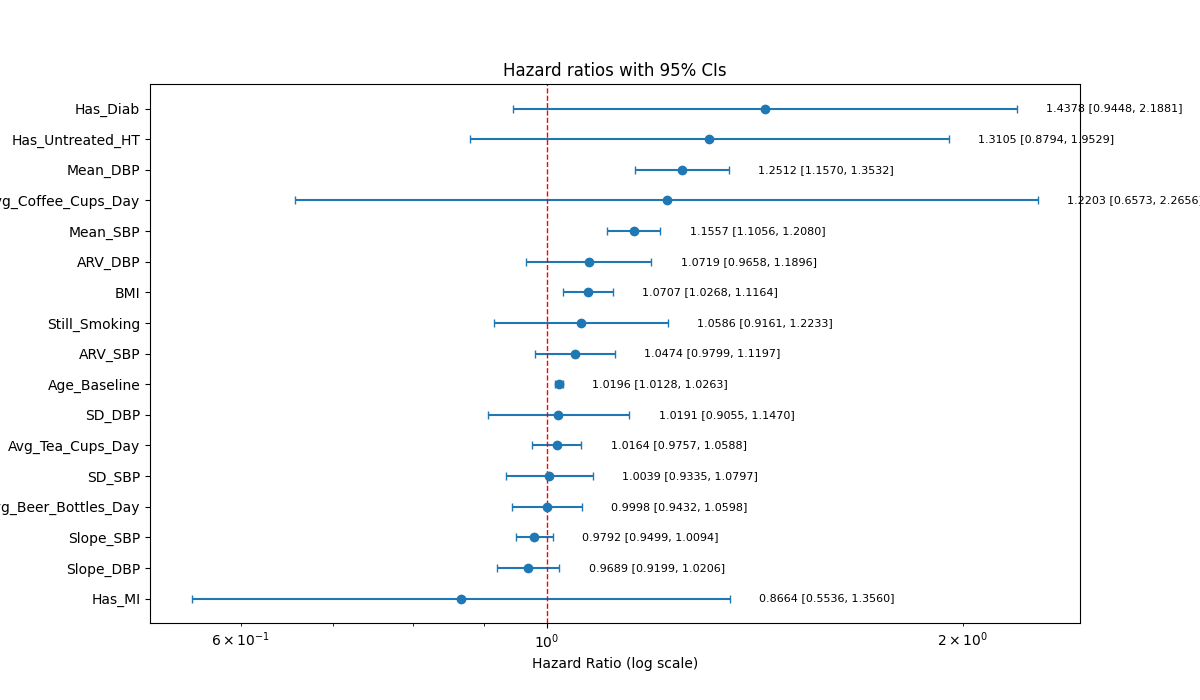

In [27]:
cph_df = df_person[['Time_Yrs', 'Event', 'Slope_SBP', 'Slope_DBP', 'Mean_SBP', 'Mean_DBP', 'SD_SBP', 'SD_DBP', 'ARV_SBP', 'ARV_DBP',
                    'Age_Baseline', 'BMI', 'Has_Untreated_HT', 'Has_Diab', 'Has_MI', 'Still_Smoking',
                    'Avg_Beer_Bottles_Day', 'Avg_Coffee_Cups_Day', 'Avg_Tea_Cups_Day', ]].copy()
cph_df = cph_df.dropna()

cph = CoxPHFitter(penalizer=0.1)
cph.fit(cph_df, duration_col='Time_Yrs', event_col='Event', show_progress=True)
cph.print_summary(decimals=4)

summary_df = cph.summary

# normalize expected column names (handle lifelines naming)
col_map = {
    "se(coef)": "se",
    "coef lower 95%": "coef_lower",
    "coef upper 95%": "coef_upper",
}
summary_df = summary_df.rename(columns=col_map)

# pick scaling for readability (e.g., show Mean_Sbp and Mean_Dbp per 10 mmHg)
scale_map = {
    'Mean_SBP': 10.0,
    'Mean_DBP': 10.0,
    'SD_SBP': 10.0,
    'SD_DBP': 10.0,
    'ARV_SBP': 10.0,
    'ARV_DBP': 10.0,
    'BMI': 2.0
    # keep others at 1.0
}
summary_df['scale'] = summary_df.index.map(scale_map).fillna(1.0)

# compute display coef and CI on coef scale (apply scaling to coef and CI)
summary_df['coef_disp'] = summary_df['coef'] * summary_df['scale']
summary_df['coef_lower_disp'] = summary_df['coef_lower'] * summary_df['scale']
summary_df['coef_upper_disp'] = summary_df['coef_upper'] * summary_df['scale']

# exponentiate to HR scale (display)
summary_df['hr'] = np.exp(summary_df['coef_disp'])
summary_df['hr_lower'] = np.exp(summary_df['coef_lower_disp'])
summary_df['hr_upper'] = np.exp(summary_df['coef_upper_disp'])

# order variables for plotting (you can sort by coef_disp or HR)
summary_df = summary_df.sort_values('hr')

# plotting
plt.figure(figsize=(12, 7))
y_pos = np.arange(len(summary_df))
hr = summary_df['hr'].values
hr_err_low = hr - summary_df['hr_lower'].values
hr_err_high = summary_df['hr_upper'].values - hr
variable_labels = summary_df.index.values

# horizontal error bars on log scale (plot HR on log x-axis)
plt.errorbar(hr, y_pos, xerr=[hr_err_low, hr_err_high], fmt='o', capsize=3)
plt.axvline(1.0, color='red', linestyle='--', linewidth=1)  # null hazard ratio

plt.yticks(y_pos, variable_labels)
plt.xscale('log')
plt.xlabel('Hazard Ratio (log scale)')
plt.title('Hazard ratios with 95% CIs')

# annotate HR values to the right
for i, (h, lo, hi) in enumerate(zip(hr, summary_df['hr_lower'], summary_df['hr_upper'])):
    plt.text(hi * 1.05, i, f"{h:.4f} [{lo:.4f}, {hi:.4f}]", va='center', fontsize=8)

plt.show()

From the results,

#### 1. Statistically significant predictors ($p < 0.05$, $-\log_2 p > 2.9957$)

1. Mean of DBP ($\beta = 0.0224$, $p < 5 \times 10^{-5}$)
2. Age at baseline ($\beta = 0.0194$, $p < 5 \times 10^{-5}$)
3. Mean of SBP ($\beta = 0.0145$, $p < 5 \times 10^{-5}$)
4. BMI ($\beta = 0.0344$, $p=0.0012$)

#### 2. Valid predictors

Valid predictors are defined by predictors with both upper and lower hazard ratios under or over 1.

1. Mean DBP (HR = 1.2513 per 10 mmHg increase)
2. Mean SBP (HR = 1.1557 per 10 mmHg increase)
3. BMI (HR = 1.0713 per 2.0 increase in BMI)
4. Age at baseline (HR = 1.0196 per 1 year increase)

Additionally, slope of SBP and DBP are related to stroke risk, but with low statistical significance ($-\log_2 p = 2.5287$,
$p > 0.05$ respectively).

Meanwhile, variation of SBP and DBP (Standard Deviation and Average Real Variability of SBP and DBP) have little effect on stroke risk
($\beta < 0.0069$ per mmHg increase), but statistical significance is also low ($p > 0.05$), and their predictors in the Cox model are
not valid. Some life habit factors (consumption of beverages), have effect on stroke risk ($\beta$ for coffee drinking = 0.1991,
$\beta$ for tea drinking = 0.0163). However, their statistical significances are low ($p > 0.05$), and their predictors are not valid
in the Cox model.

Therefore, by comparing trends of BP and stroke occurence, it can be seen that trends of BP (measured by slope of SBP and DBP) has no
statistically significant relation with stroke risk. However, it is true that for a generally high BP over the years (especially higher
DBP), can lead to a higher risk of stroke.

From results, if a proactive BP scheme were implemented, it should be prioritized for those who

1. Has higher DBP or SBP
2. Has higher BMI
3. Are older

, as such factors are more correlated with stroke risk than others.

## References

```
Boehme, A. K., Esenwa, C., & Elkind, M. S. (2017). Stroke Risk Factors, Genetics, and Prevention. Circ Res, 120(3), 472–495. https://doi.org/10.1161/circresaha.116.308398 
Centre for Health Prevention. (2025). Non-Communicable Diseases Watch October 2025 - Be Stroke Aware. Centre for Health Prevention. https://www.chp.gov.hk/files/pdf/ncd_watch_oct_2025_en.pdf
Han, T. S., Wang, H. H., Wei, L., Pan, Y., Ma, Y., Wang, Y., Wang, J., Hu, Z., Sharma, P., & Chen, R. (2017). Impacts of undetected and inadequately treated hypertension on incident stroke in China. BMJ Open, 7(10), e016581. https://doi.org/10.1136/bmjopen-2017-016581
```